<a href="https://colab.research.google.com/github/yakirhelets/ddsp_demo/blob/master/DDSPDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title #Install and Import

#@markdown Install ddsp, define some helper functions, and download the model. This transfers a lot of data and _should take a minute or two_.
#@markdown * Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
#@markdown * Press the ▶️ button on the left of each of the cells

%tensorflow_version 2.x

print('Installing from pip package...')
!pip install -qU ddsp
print('\nHang on! Copying sources...')
!git clone https://github.com/yakirhelets/ddsp_demo.git

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import time

import crepe
import ddsp
import ddsp.training
from ddsp.colab.colab_utils import (download, play, record, specplot, upload,
                                    DEFAULT_SAMPLE_RATE, audio_bytes_to_np)
import gin
from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Helper Functions
sample_rate = DEFAULT_SAMPLE_RATE  # 16000


print('Done!')

Installing from pip package...
     |████████████████████████████████| 92kB 2.4MB/s 
     |████████████████████████████████| 3.3MB 8.7MB/s 
     |████████████████████████████████| 368kB 31.1MB/s 

Hang on! Copying sources...
Cloning into 'ddsp_demo'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 2), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.
Done!


Saving singing.mp3 to singing (1).mp3
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.5569759e-07
 -1.4508151e-07  0.0000000e+00]

Extracting audio features...


[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.5569759e-07
  -1.4508151e-07  0.0000000e+00]]


KeyboardInterrupt: ignored

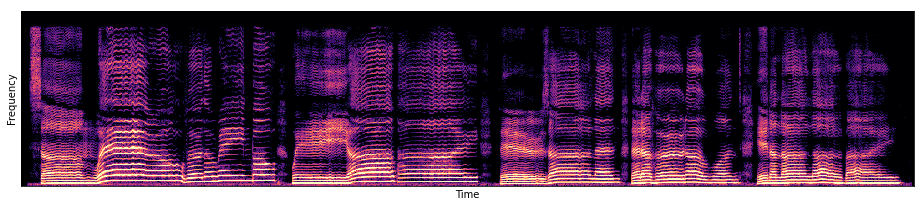

In [20]:
#@title Upload Audio File
#@markdown * Either use the provided example or upload audio from file (.mp3 or .wav) 
#@markdown * Audio should be monophonic (single instrument / voice)
#@markdown * Extracts fundmanetal frequency (f0) and loudness features. 

example_or_upload = "Upload (.mp3 or .wav)"  #@param ["Example - Singing", "Upload (.mp3 or .wav)"]

if example_or_upload == "Example - Singing":
  # audio = record(seconds=record_seconds)
  example_path = "/content/ddsp_demo/sources/audio_examples/somewhere_over_the_rainbow.mp3"
  
  # with open(example_path, 'ab') as f:
  #       f.write(data)

  with open(example_path, "rb") as file_audio:
    audio_as_bytes = file_audio.read()
  audio = audio_bytes_to_np(audio_as_bytes)
  print(audio)
else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
  filenames, audios = upload()
  audio = audios[0]
  print(audio)
audio = audio[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio)
play(audio)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
print(audio)
audio_features = ddsp.training.eval_util.compute_audio_features(audio)
print(audio)
audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
print(audio)
audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))


# Plot Features.
fig, ax = plt.subplots(nrows=3, 
                       ncols=1, 
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz']))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')

In [0]:
#@title Choose a model

model = 'Violin' #@param ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone','Our model']
MODEL = model

GCS_CKPT_DIR = 'gs://ddsp/models/tf2'

def find_model_dir(dir_name):
  # Iterate through directories until model directory is found
  for root, dirs, filenames in os.walk(dir_name):
    for filename in filenames:
      if filename.endswith(".gin") and not filename.startswith("."):
        model_dir = root
        break
  return model_dir 


if model in ('Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone'):
  # Pretrained models.
  PRETRAINED_DIR = '/content/pretrained'
  # Copy over from gs:// for faster loading.
  !rm -r $PRETRAINED_DIR &> /dev/null
  !mkdir $PRETRAINED_DIR &> /dev/null
  model_dir = os.path.join(GCS_CKPT_DIR, 'solo_%s_ckpt' % model.lower())
  !gsutil cp $model_dir/* $PRETRAINED_DIR &> /dev/null
  model_dir = PRETRAINED_DIR
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')

else:
  # User models.
  UPLOAD_DIR = '/content/uploaded'
  !mkdir $UPLOAD_DIR
  uploaded_files = files.upload()

  for fnames in uploaded_files.keys():
    print("Unzipping... {}".format(fnames))
    !unzip -o "/content/$fnames" -d $UPLOAD_DIR &> /dev/null
  model_dir = find_model_dir(UPLOAD_DIR)
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')

# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('DefaultPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Additive.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Additive.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'DefaultPreprocessor.time_steps = {}'.format(time_steps),
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Saving acoustic_45k.zip to acoustic_45k.zip
Unzipping... acoustic_45k.zip
Restoring model took 0.7 seconds



User uploaded model: disabling auto-adjust.


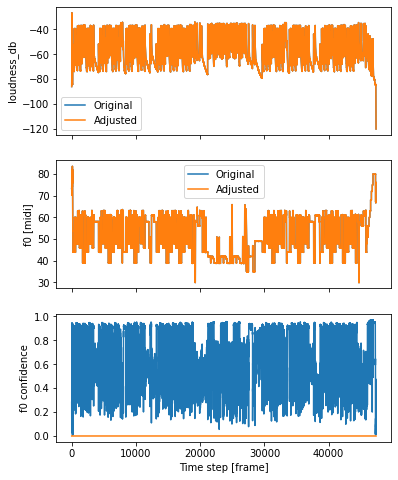

In [0]:
#@title Modify conditioning

#@markdown These models were not explicitly trained to perform timbre transfer, so they may sound unnatural if the incoming loudness and frequencies are very different then the training data (which will always be somewhat true). 

#@markdown This button will at least adjusts the average loudness and pitch to be similar to the training data (although not for user trained models).

auto_adjust = True #@param{type:"boolean"}

#@markdown You can also make additional manual adjustments:
#@markdown * Shift the fundmental frequency to a more natural register.
#@markdown * Silence audio below a threshold on f0_confidence.
#@markdown * Adjsut the overall loudness level.
f0_octave_shift =  0 #@param {type:"slider", min:-2, max:2, step:1}
f0_confidence_threshold =  0 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
loudness_db_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}

#@markdown You might get more realistic sounds by shifting a few dB, or try going extreme and see what weird sounds you can make...

audio_features_mod = {k: v.copy() for k, v in audio_features.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, f0_octave_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (f0_octave_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features


def mask_by_confidence(audio_features, confidence_level=0.1):
  """For the violin model, the masking causes fast dips in loudness. 
  This quick transient is interpreted by the model as the "plunk" sound.
  """
  mask_idx = audio_features['f0_confidence'] < confidence_level
  audio_features['f0_hz'][mask_idx] = 0.0
  # audio_features['loudness_db'][mask_idx] = -ddsp.spectral_ops.LD_RANGE
  return audio_features


def smooth_loudness(audio_features, filter_size=3):
  """Smooth loudness with a box filter."""
  smoothing_filter = np.ones([filter_size]) / float(filter_size)
  audio_features['loudness_db'] = np.convolve(audio_features['loudness_db'], 
                                           smoothing_filter, 
                                           mode='same')
  return audio_features

if auto_adjust:
  if MODEL in ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Saxophone', 'Tenor_Saxophone']:
    # Adjust the peak loudness.
    l = audio_features['loudness_db']
    model_ld_avg_max = {
        'Violin': -34.0,
        'Flute': -45.0,
        'Flute2': -44.0,
        'Trumpet': -52.3,
        'Tenor_Saxophone': -31.2
    }[MODEL]
    ld_max = np.max(audio_features['loudness_db'])
    ld_diff_max = model_ld_avg_max - ld_max
    audio_features_mod = shift_ld(audio_features_mod, ld_diff_max)

    # Further adjust the average loudness above a threshold.
    l = audio_features_mod['loudness_db']
    model_ld_mean = {
        'Violin': -44.0,
        'Flute': -51.0,
        'Flute2': -53.0,
        'Trumpet': -69.2,
        'Tenor_Saxophone': -50.8
    }[MODEL]
    ld_thresh = -70.0
    ld_mean = np.mean(l[l > ld_thresh])
    ld_diff_mean = model_ld_mean - ld_mean
    audio_features_mod = shift_ld(audio_features_mod, ld_diff_mean)

    # Shift the pitch register.
    model_p_mean = {
        'Violin': 73.0,
        'Flute': 81.0,
        'Flute2': 74.0,
        'Trumpet': 65.8,
        'Tenor_Saxophone': 57.8
    }[MODEL]
    p = librosa.hz_to_midi(audio_features['f0_hz'])
    p[p == -np.inf] = 0.0
    p_mean = p[l > ld_thresh].mean()
    p_diff = model_p_mean - p_mean
    p_diff_octave = p_diff / 12.0
    round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
    p_diff_octave = round_fn(p_diff_octave)
    audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)

  else:
    print('\nUser uploaded model: disabling auto-adjust.')

  
audio_features_mod = shift_ld(audio_features_mod, loudness_db_shift)
audio_features_mod = shift_f0(audio_features_mod, f0_octave_shift)
audio_features_mod = mask_by_confidence(audio_features_mod, f0_confidence_threshold)


# Plot Features.
fig, ax = plt.subplots(nrows=3, 
                       ncols=1, 
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'])
ax[0].plot(audio_features_mod['loudness_db'])
ax[0].set_ylabel('loudness_db')
ax[0].legend(['Original','Adjusted'])

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz']))
ax[1].plot(librosa.hz_to_midi(audio_features_mod['f0_hz']))
ax[1].set_ylabel('f0 [midi]')
ax[1].legend(['Original','Adjusted'])

ax[2].plot(audio_features_mod['f0_confidence'])
ax[2].plot(np.ones_like(audio_features_mod['f0_confidence']) * f0_confidence_threshold)
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')

In [0]:
#@title #Resynthesize Audio

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
audio_gen = model(af, training=False)
print('Prediction took %.1f seconds' % (time.time() - start_time))

# Plot
print('Original')
play(audio)

print('Resynthesis')
play(audio_gen)

specplot(audio)
plt.title("Original")

specplot(audio_gen)
_ = plt.title("Resynthesis")

NameError: ignored